## Imports and Configurations

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import os,sys
from sklearn import preprocessing, linear_model
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error


from matplotlib import pyplot as plt

pd.set_option("display.max_rows",20)
pd.set_option("display.max_columns",20)

from sklearn.preprocessing import Imputer, OneHotEncoder

### Utility Functions

In [3]:
from sklearn.preprocessing import Imputer, OneHotEncoder

def categoricalToNumerical(dframe,removeFeatureList):

    all_features = list(dframe)

    categorical_features = [feature for feature in all_features if dframe[feature].dtype == 'O']
    numerical_features = [feature for feature in all_features if dframe[feature].dtype in ['int64','float64']]

    if removeFeatureList:
        for feature in removeFeatureList:
            if feature in categorical_features:
                categorical_features.remove(feature)
            elif feature in numerical_features:
                numerical_features.remove(feature)
            else:
                raise Exception('Feature in list of features to remove is neither categorical or numerical')
        

    oneHotEncoded_categoricalFeatures = [pd.get_dummies(dframe[feature],prefix=feature) for feature in categorical_features]
        
    featureSet1 = []
    featureSet2 = []

    if len(oneHotEncoded_categoricalFeatures)>1:
        featureSet1 = pd.concat([feature for feature in oneHotEncoded_categoricalFeatures],axis=1)

    elif len(oneHotEncoded_categoricalFeatures)==1:
        featureSet1 = oneHotEncoded_categoricalFeatures[0]
    
    else:
        if len(numerical_features)==0:
            raise ValueError('DataFrame has no columns')

    if len(numerical_features)>1:
        featureSet2 = pd.concat([dframe[feature] for feature in numerical_features],axis=1)

    elif len(numerical_features)==1:
        featureSet2 = dframe.loc[:,[numerical_features[0]]]

    else:
        if len(oneHotEncoded_categoricalFeatures)==0:
            raise ValueError('DataFrame has no columns')   

    
    #featureSet1 = pd.concat([feature for feature in oneHotEncoded_categoricalFeatures],axis=1)
    #featureSet2 = pd.concat([dframe[feature] for feature in numerical_features],axis=1)

    return featureSet1,featureSet2

def normalizeCols(ser):

    ser = ser.astype('float64')
    min_max_scaler = preprocessing.MinMaxScaler()
    ser = ser.fillna(ser.mean())
    ser = np.array(ser).reshape(-1,1)

    ans = min_max_scaler.fit_transform(ser)

    #return ans.flatten()
    return pd.Series(ans.flatten())

def plot_graph(X,Y_actual,Y_predicted,color1,color2,linewidth,target_variable,singular_feature):
    
    #Mode of the graph plot function:
    #Mode==0 for plotting a feature against the target variable
    #mode == 1 for plotting Rang of length of samples against the target variable.
    #Mode 1 shows how the predicted output fits the actual ouput. A higher MSE Value would lead to poor fit. 
    
    plt.figure(figsize=(10,5))
    
    plt.scatter(X,Y_actual,color=color1,label='Data')
    plt.plot(X,Y_predicted,color=color2,label="Prediction",linewidth=1)
    plt.ylabel(target_variable)
    plt.xlabel(singular_feature)

## Linear Regression Function

In [4]:
def regressionPerTarget(target,dframe,mode,input_variable,remove_additional_features):
    target_variable = target
    f3 = dframe
    features_to_remove = []
    if not remove_additional_features:
        features_to_remove = ["Date","Key",target_variable]
    else:
        features_to_remove = ["Date","Key",target_variable]+remove_additional_features
        
    cat_feat, num_feat = categoricalToNumerical(f3,features_to_remove)
    
    #Normalize and add missing valuses
    for feature in list(num_feat):
        num_feat[feature]= normalizeCols(num_feat[feature])
        
    #Combine the categorical and numerical features
    loadprediction_samples = pd.concat([cat_feat,num_feat],axis=1)
    
    #Prepare the Target Variable
    loadprediction_groundTruth = f3.loc[:,[target_variable]]
    loadprediction_groundTruth = loadprediction_groundTruth.fillna(loadprediction_groundTruth.mean())
    
    if mode == 1 and input_variable != None:
        print("Entered Single Input - Rest Mean mode")
        meaned_loadprediction_samples = pd.DataFrame()
        for feature in list(loadprediction_samples):
            if feature != input_variable:
                meaned_loadprediction_samples[feature]=pd.Series(np.full(loadprediction_samples[feature].shape,loadprediction_samples[feature].mean()))
            else:
                meaned_loadprediction_samples[input_variable]=pd.Series(loadprediction_samples[input_variable].values)    
        loadprediction_samples = pd.DataFrame(meaned_loadprediction_samples)
      
    
    #Split teh dataset
    x_train, x_test, y_train, y_test = train_test_split(loadprediction_samples,loadprediction_groundTruth,test_size=0.3,shuffle=True,random_state=10)

    #Linear Regression
    lm = linear_model.LinearRegression()
    model = lm.fit(x_train, y_train)
    predictions = lm.predict(x_test)
    y_pred = predictions.ravel()

    #Uses the R^2 metric
    r2 = model.score(x_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    
    cat_feat = cat_feat.astype('float64')
    return r2,mse,cat_feat,num_feat,loadprediction_samples,loadprediction_groundTruth,lm,x_train,x_test,y_train,y_test, predictions

## Reading data into memory

In [6]:
data = "../data/"
csvfiles = os.listdir(data)

if '.DS_Store' in csvfiles:
    csvfiles.remove('.DS_Store')

#print (csvfiles)

#f1 = pd.read_csv(data+csvfiles[0],low_memory=False)
#f2 = pd.read_csv(data+csvfiles[1],low_memory=False)
#f3 = pd.read_csv(data+csvfiles[2],low_memory=False)
#f4 = pd.read_csv(data+csvfiles[3],low_memory=False)
f3 = pd.read_csv(data+'trainingload excel report 1527265035365.csv',low_memory=False)
f4 = pd.read_csv(data+'gpscatapultuploader excel report 1527265475004.csv',low_memory=False)
f4

['gpscatapultuploader excel report 1527265475004.csv', 'trainingavailability excel report 1527265061608.csv', 'trainingload excel report 1527265035365.csv', 'wellness excel report 1527265037959.csv']


,Date,Key,Session Type,Training Status,Position,Line,Period Name,Period Number,Total Duration,Total Distance,...,PLSlow 7D SDS,EE 7D SDS,Collisions 7D SDS,HID 7D SDS,TD 14D SDS,PL 14D SDS,PLSlow 14D SDS,EE 14D SDS,Collisions 14D SDS,HID 14D SDS
0,27/02/2018,Player 108,Conditioning,Full Training,Linebacker,Defense,Session,0.0,01:12:19,0.00000,...,1.95,0.70,-0.14,-0.61,-1.30,0.50,1.81,0.76,-0.11,-0.61
1,27/02/2018,Player 108,Conditioning,Full Training,Linebacker,Defense,STRETCH,1.0,00:14:32,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,27/02/2018,Player 108,Conditioning,Full Training,Linebacker,Defense,8 STATION,2.0,00:32:12,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,27/02/2018,Player 108,Conditioning,Full Training,Linebacker,Defense,4 STATION,3.0,00:16:33,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,27/02/2018,Player 108,Conditioning,Full Training,Linebacker,Defense,INDY,4.0,00:09:01,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,27/02/2018,Player 26,Conditioning,Full Training,Offensive Line,Offense,Session,0.0,00:46:55,0.00000,...,1.68,-0.12,-0.30,-0.44,-1.54,0.05,1.60,-0.30,-0.35,-0.44
6,27/02/2018,Player 26,Conditioning,Full Training,Offensive Line,Offense,STRETCH,1.0,00:14:32,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,27/02/2018,Player 26,Conditioning,Full Training,Offensive Line,Offense,8 STATION,2.0,00:23:21,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,27/02/2018,Player 26,Conditioning,Full Training,Offensive Line,Offense,INDY,3.0,00:09:01,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,27/02/2018,Player 24,Conditioning,Full Training,Wide Receiver,Offense,Session,0.0,01:12:19,0.00000,...,1.66,1.74,-0.35,-0.75,-1.27,-0.29,1.31,1.54,-0.34,-0.75


## Exploring the trainingload dataset for Load Prediction

In [51]:
f3

,Date,Key,Phase of Season,Session Type,RPE,RPE type,Duration,Overall load,Acute Load Total,Acute Load Average,...,TSB,Last 14d minimum,TSB Flag,Last week,Two weeks ago,LWk%change,Muscle soreness,Fatigue,Sleep,Weekly Load
0,27/02/2018,Player 1,Winter Conditioning,Conditioning,8.0,Group average,60,480.0,1590,398,...,1.04,1.00,No,1110.0,1590.0,-43.24,NaN,NaN,NaN,1590.001
1,27/02/2018,Player 3,Winter Conditioning,Conditioning,8.0,Group average,60,480.0,1590,398,...,1.04,1.00,No,1110.0,1590.0,-43.24,NaN,NaN,NaN,1590.001
2,27/02/2018,Player 7,Winter Conditioning,Conditioning,8.0,Group average,60,480.0,1410,352,...,1.14,1.00,No,930.0,1230.0,-32.26,NaN,NaN,NaN,1410.003
3,27/02/2018,Player 8,Winter Conditioning,Rehab,5.0,Group average,60,300.0,1230,308,...,1.13,1.00,No,930.0,1050.0,-12.90,NaN,NaN,NaN,1229.998
4,27/02/2018,Player 4,Winter Conditioning,Conditioning,8.0,Group average,60,480.0,1410,352,...,1.02,0.88,No,930.0,1410.0,-51.61,NaN,NaN,NaN,1410.003
5,27/02/2018,Player 6,Winter Conditioning,Conditioning,8.0,Group average,60,480.0,1590,398,...,1.04,1.00,No,1110.0,1590.0,-43.24,NaN,NaN,NaN,1590.001
6,27/02/2018,Player 96,Winter Conditioning,Conditioning,8.0,Group average,60,480.0,1590,398,...,1.04,1.00,No,1110.0,1590.0,-43.24,NaN,NaN,NaN,1590.001
7,27/02/2018,Player 102,Winter Conditioning,Conditioning,8.0,Group average,60,480.0,1590,398,...,1.04,1.00,No,1110.0,1590.0,-43.24,NaN,NaN,NaN,1590.001
8,27/02/2018,Player 90,Winter Conditioning,Conditioning,8.0,Group average,60,480.0,1590,398,...,1.04,1.00,No,1110.0,1590.0,-43.24,NaN,NaN,NaN,1590.001
9,27/02/2018,Player 94,Winter Conditioning,Conditioning,8.0,Group average,60,480.0,1590,398,...,1.04,1.00,No,1110.0,1590.0,-43.24,NaN,NaN,NaN,1590.001


In [52]:
#Selecting Weekly Load as the feature to predict
target_variable = "RPE"
input_variable = "Acute Load Average"

remove_additional_features = ['Phase of Season','Session Type','RPE type','Overall load','Acute Load Total','Monotony','Strain','TSB Flag','Last week','Two weeks ago', 'LWk%change','Weekly Load']


In [53]:
r2,mse,cat_feat,num_feat,loadprediction_samples,loadprediction_groundTruth,lm,x_train,x_test,y_train,y_test,predictions= regressionPerTarget(target_variable,f3,0,input_variable,remove_additional_features)

## Categorical Features converted to One Hot Encoded Vectors

In [54]:
#cat_feat, num_feat = categoricalToNumerical(f3,["Date","Key",target_variable])
#cat_feat = cat_feat.astype('float64')
cat_feat

,Muscle soreness_Average,Muscle soreness_High,Muscle soreness_Low,Muscle soreness_Very High,Muscle soreness_Very Low,Fatigue_Average,Fatigue_High,Fatigue_Low,Fatigue_Very High,Fatigue_Very Low,Sleep_Average,Sleep_High,Sleep_Low,Sleep_Very High,Sleep_Very Low
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Numerical Features: Normalized and without Missing Values

In [55]:
num_feat    

,Duration,Acute Load Average,Chronic Load Average,TSB,Last 14d minimum
0,0.166667,0.101571,0.112869,0.208817,0.284768
1,0.166667,0.101571,0.112869,0.208817,0.284768
2,0.166667,0.088664,0.087553,0.232019,0.284768
3,0.166667,0.076319,0.074895,0.229698,0.284768
4,0.166667,0.088664,0.100211,0.204176,0.245033
5,0.166667,0.101571,0.112869,0.208817,0.284768
6,0.166667,0.101571,0.112869,0.208817,0.284768
7,0.166667,0.101571,0.112869,0.208817,0.284768
8,0.166667,0.101571,0.112869,0.208817,0.284768
9,0.166667,0.101571,0.112869,0.208817,0.284768


## Preprocessed dataset for load prediction

In [56]:
#loadprediction_samples = pd.concat([cat_feat,num_feat],axis=1)
loadprediction_samples

,Muscle soreness_Average,Muscle soreness_High,Muscle soreness_Low,Muscle soreness_Very High,Muscle soreness_Very Low,Fatigue_Average,Fatigue_High,Fatigue_Low,Fatigue_Very High,Fatigue_Very Low,Sleep_Average,Sleep_High,Sleep_Low,Sleep_Very High,Sleep_Very Low,Duration,Acute Load Average,Chronic Load Average,TSB,Last 14d minimum
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.166667,0.101571,0.112869,0.208817,0.284768
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.166667,0.101571,0.112869,0.208817,0.284768
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.166667,0.088664,0.087553,0.232019,0.284768
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.166667,0.076319,0.074895,0.229698,0.284768
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.166667,0.088664,0.100211,0.204176,0.245033
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.166667,0.101571,0.112869,0.208817,0.284768
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.166667,0.101571,0.112869,0.208817,0.284768
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.166667,0.101571,0.112869,0.208817,0.284768
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.166667,0.101571,0.112869,0.208817,0.284768
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.166667,0.101571,0.112869,0.208817,0.284768


## Ground Truth Labels

In [57]:
#loadprediction_groundTruth = f3.loc[:,[target_variable]]
#loadprediction_groundTruth = loadprediction_groundTruth.fillna(loadprediction_groundTruth.mean())
loadprediction_groundTruth

,RPE
0,8.0
1,8.0
2,8.0
3,5.0
4,8.0
5,8.0
6,8.0
7,8.0
8,8.0
9,8.0


In [58]:
#singular_feature = 'Strain'
#meaned_loadprediction_samples = pd.DataFrame()
#for feature in list(loadprediction_samples):
    #if feature != singular_feature:
        #meaned_loadprediction_samples[feature]=pd.Series(np.full(loadprediction_samples[feature].shape,loadprediction_samples[feature].mean()))
    #else:
        #meaned_loadprediction_samples[singular_feature]=pd.Series(loadprediction_samples[singular_feature].values)    
#loadprediction_samples = pd.DataFrame(meaned_loadprediction_samples)
loadprediction_samples

,Muscle soreness_Average,Muscle soreness_High,Muscle soreness_Low,Muscle soreness_Very High,Muscle soreness_Very Low,Fatigue_Average,Fatigue_High,Fatigue_Low,Fatigue_Very High,Fatigue_Very Low,Sleep_Average,Sleep_High,Sleep_Low,Sleep_Very High,Sleep_Very Low,Duration,Acute Load Average,Chronic Load Average,TSB,Last 14d minimum
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.166667,0.101571,0.112869,0.208817,0.284768
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.166667,0.101571,0.112869,0.208817,0.284768
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.166667,0.088664,0.087553,0.232019,0.284768
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.166667,0.076319,0.074895,0.229698,0.284768
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.166667,0.088664,0.100211,0.204176,0.245033
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.166667,0.101571,0.112869,0.208817,0.284768
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.166667,0.101571,0.112869,0.208817,0.284768
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.166667,0.101571,0.112869,0.208817,0.284768
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.166667,0.101571,0.112869,0.208817,0.284768
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.166667,0.101571,0.112869,0.208817,0.284768


## Splitting the dataset into train and test set

In [59]:
#x_train, x_test, y_train, y_test = train_test_split(loadprediction_samples,loadprediction_groundTruth,test_size=0.3,shuffle=True,random_state=10)

## Regression - Linear Regression

In [60]:
print ("R^2 Score: ",str(r2))
print ("Mean Squared Error: ",str(mse))

R^2 Score:  0.03536611236515097
Mean Squared Error:  31.848688388107117


## Observing the Actual vs Predicted Values
<a id='actual-predicted'></a>

In [61]:
YP = y_test[target_variable].values
y_pred = predictions.ravel()

act_pred = pd.DataFrame({input_variable:x_test[input_variable],'Actual': YP, 'Predicted': y_pred})
ap = act_pred.sort_values('Actual')
ap

,Acute Load Average,Actual,Predicted
9953,0.069304,0.0,4.533593
13558,0.129349,0.0,3.760954
13560,0.160494,0.0,4.208550
23555,0.069585,0.0,4.546034
23568,0.059203,0.0,3.633958
22344,0.107744,0.0,4.776133
16924,0.049944,0.0,4.037717
13267,0.164422,1.0,4.716761
8010,0.087262,1.0,3.746447
21555,0.019080,1.0,4.237102


### Frequency Distribution of Target Variable

Text(0,0.5,'Frequency')

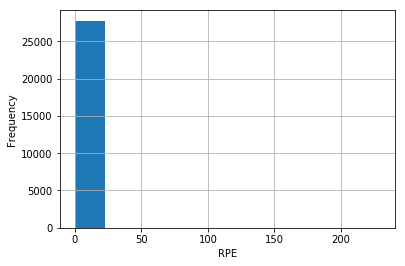

In [62]:
hist = f3[target_variable].hist(bins=10)

plt.xlabel(target_variable)
plt.ylabel("Frequency")

Text(0.5,0,'Range of Target Variable Values')

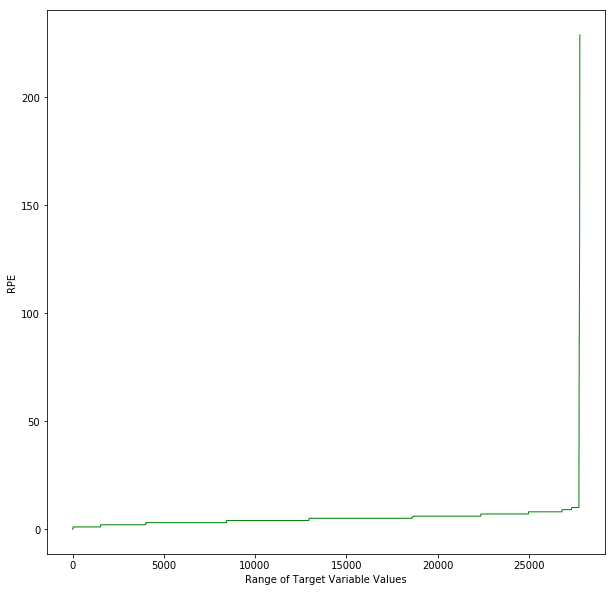

In [63]:
plt.figure(figsize=(10,10))
yft = f3[target_variable].sort_values()
xft = list(range(len(yft)))
plt.plot(xft,yft,color='green',label="Prediction", linewidth=1)
plt.ylabel(target_variable)
plt.xlabel("Range of Target Variable Values")

## Analyzing the regression function based on a single input variable<a id='analyzing-regression'></a>

### Regression line of single feature over the target variable

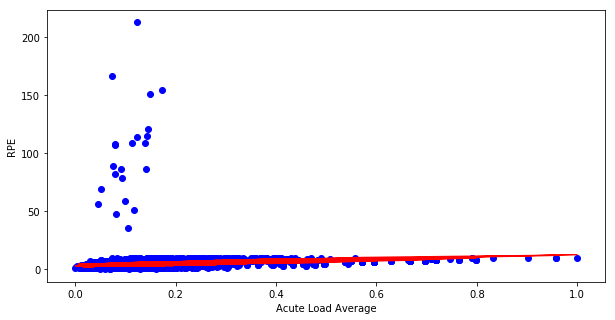

In [64]:
plot_graph(ap[input_variable],ap['Actual'],ap['Predicted'],"blue","red",1,target_variable,input_variable)

### Comparison of Predicted Output vs Actual Output
##### Predicted overlaps with a large MSE

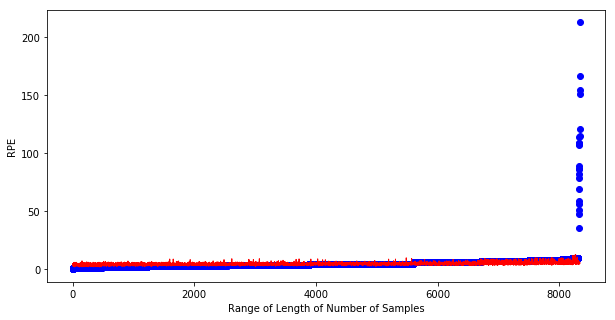

In [65]:
range_index_x_test = np.array(list(range(len(ap[input_variable]))))
plot_graph(range_index_x_test,ap['Actual'],ap['Predicted'],"blue","red",1,target_variable,"Range of Length of Number of Samples")

## Cross Validation of results using 10-Fold CV

In [66]:
from sklearn import model_selection

kfold = model_selection.KFold(n_splits=5)
results = model_selection.cross_val_score(lm, x_train, y_train, cv=kfold, scoring='r2')
"R ^2: "+str(results.mean())

'R ^2: 0.05711763137978252'

## Regression for all numerical features as target variables

In [68]:
numeric_target_features = [feature for feature in list(f3) if f3[feature].dtype in ['int64','float64']]
r2list = [regressionPerTarget(target,f3,mode=0,input_variable=None,remove_additional_features=None)[0] for target in list(numeric_target_features)]
mselist = [regressionPerTarget(target,f3,mode=0,input_variable=None,remove_additional_features=None)[1] for target in list(numeric_target_features)]
pd.DataFrame({'Numerical Features as Targets': list(numeric_target_features), 'R^2 Values': r2list, 'MSE Values': mselist})


,Numerical Features as Targets,R^2 Values,MSE Values
0,RPE,0.153911,27.934762
1,Duration,0.811047,509.007876
2,Overall load,0.859605,24355.483907
3,Acute Load Total,1.000000,0.016204
4,Acute Load Average,0.941495,6086.361512
5,Monotony,0.862756,0.017785
6,Strain,0.944093,282211.736520
7,Chronic Load Average,0.920332,6560.208092
8,TSB,0.813524,0.020081
9,Last 14d minimum,0.523789,0.032650


## Comments

#### 1. R^2 and Mean Square Error (MSE) are two scoring function to find the difference between the actual and predicted values of the test set.
#### 2. For R^2, 1.0 is a perfect fit and for MSE values closer to 0 describe minimum difference. 
#### 3. When "Weekly Load" was selected as the target feature to predict we got a perfect fit and the predicted values were very close to the actual values. The difference is visualized in [Observing the Actual vs Predicted Values](#actual-predicted)
#### 4. Though, as seen in [Analyzing the Regression Fuction](#analyzing-regression) the model overfits. This could be because of various reasons one of them being the test set having low variance and similar values to the training set. This effect was seen even through k-fold cross validation. Another reason could be a very good linear relationship between the target variable and the other features. This occurs when the target is calculated with a linear function over other features. 
#### 5. We could use regularization as a technique to improve overfitting but then the MSE scores would go up as the model learns to generalize. This means it would make incorrect test predictions. We could test that on new a new training set or drop features to remove features with a linear relationship.
#### 6. Feature Elimination: Through recursive feature elimination it was found that only the numerical feature were selected for regression. Though that provides the same fit as the baseline regression
#### 7. Feature EElimination: The following features were excluded as a test "Overall load","Acute Load Total","Acute Load Average" and the R^2 was reduced to 0.91 whereas the MSE increased to 127008
#### 8. Correction: The above model does not seem to overfit, the graphs above display the accuracy(in terms of MSE) of the regression with the actual data. The low MSE values are the best indicator of the regression model.  

## Ignore the Experimental Section below

### Regression: Multi-Layer Perceptron

In [ ]:
mlp = MLPRegressor(hidden_layer_sizes=(30,30,30), max_iter=2000,alpha=1.0,solver='adam',learning_rate_init=0.001,learning_rate='adaptive', tol=0.01,verbose=True,warm_start=True)
mlp_obj = mlp.fit(x_train.values,y_train.values.ravel())
mlp_obj

In [ ]:
prediction_mlp = mlp.predict(x_test)
#type(prediction_mlp)
#prediction_mlp.shape
"R^2 Score:"+str(mlp.score(x_test, y_test))


In [ ]:
p = loadprediction_samples.loc[2,:]
p = p.values.reshape(1,-1)
#p.shape

#print (loadprediction_groundTruth.loc[2,:])
#mlp.predict(p)

act_pred = pd.DataFrame({'Strain':x_test["Strain"],'Actual': YP, 'Predicted': prediction_mlp})
ap = act_pred.sort_values('Actual')
ap

In [ ]:
#plt.scatter(y_test, prediction_mlp)
#plt.xlabel("True Values")
#plt.ylabel("Predictions")

plt.figure(figsize=(10,10))

#XP = x_test["Strain"].values.reshape(-1,1)
#YP = y_test[target_variable].values
#y_pred = prediction_mlp.ravel()

#plt.scatter(x_test, predictions,color='green')
#plt.scatter(XP,YP,color='green')
#plt.plot(XP,y_pred, color='red')

plt.scatter(loadprediction_samples["Strain"],loadprediction_groundTruth,color='blue',label='Data')
plt.plot(ap['Strain'],ap['Predicted'],color='red',label="Prediction")
plt.xlabel("Strain")
plt.ylabel(target_variable)


## Cross Validation of results using 10-Fold CV

In [ ]:
from sklearn import model_selection

kfold = model_selection.KFold(n_splits=5)
results = model_selection.cross_val_score(mlp, X, Y, cv=kfold, scoring='r2')
"R ^2: "+str(results.mean())

### Debugging - Ignore the sections below this

In [62]:
#imp = Imputer(missing_values='NaN',strategy='mean',axis=0)
#print (imp.fit(f2))
import pandas as pd
pd.set_option("display.max_rows",27801)
pd.set_option("display.max_columns",27801)

In [ ]:
f3.dtypes
y_train.values.shape
f3.shape

In [ ]:
#a = loadprediction_groundTruth
#a.isna().any()
#m.isnull().sum(axis=0)



In [ ]:
#Accuracy for classification
#from sklearn.metrics import accuracy_score
#y_true = y_test.values.ravel().shape
#y_pred = prediction_mlp.shape
#accuracy_score(y_true, y_pred)